In [1]:
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset,DataLoader
from torchvision.transforms.functional import pil_to_tensor
import torchvision.transforms as transforms
from tqdm import tqdm
import time
plt.style.use('classic')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For reproducibility
torch.manual_seed(1337)

In [2]:
IMG_SIZE = (128,128)

In [3]:
annotations = pd.read_csv("data/faces.csv")
annotations.iloc[0]

image_name    00001722.jpg
width                 1333
height                2000
x0                     490
y0                     320
x1                     687
y1                     664
Name: 0, dtype: object

## Centerness

Centerness is is sort of a weighting in this case. We will get our final pred by multiplying the class_score with centerness

It is the sqrt(min(l,r)/max(l,r)*min(t,b)/max(t,b)), basically the ratio of the max and min distance horizontally and vertically from the sides. The bigger the number the closer the point is to the center. This helps with the 

In [4]:
def generate_centerness_map(bbxs, feature_map_size):
    centerness_map = np.zeros(feature_map_size)
    for bbox in bbxs:
        xmin, ymin, xmax, ymax = bbox
        
        # Coord grid
        y_grid, x_grid = np.meshgrid(np.arange(feature_map_size[0]), np.arange(feature_map_size[1]), indexing='ij')

        l = x_grid - xmin  # Dist to the left
        r = xmax - x_grid  # Dist to the right
        t = y_grid - ymin  # Dist to the top
        b = ymax - y_grid  # Dist to the bottom 

        # only pos nums
        l = np.clip(l, 0, None)
        r = np.clip(r, 0, None)
        t = np.clip(t, 0, None)
        b = np.clip(b, 0, None)

        # Calculate centerness score
        centerness = np.sqrt((np.minimum(l, r) / np.maximum(l, r)) * (np.minimum(t, b) / np.maximum(t, b)))
        
        # Replace NaNs with zeros
        centerness = np.nan_to_num(centerness)
        centerness_map = np.maximum(centerness_map, centerness)
    
    return torch.tensor(centerness_map).view(1,128,128)

In [5]:
def generate_class_map(bbxs,feature_map_size):
    class_map = np.zeros((feature_map_size[0],feature_map_size[1]))
    for bbox in bbxs:
        xmin, ymin, xmax, ymax = np.array(bbox).astype(int)
        class_map[ymin:ymax,xmin:xmax]=1
    return torch.tensor(class_map).view(1,128,128)

In [6]:
def generate_bbox_map(bbxs,feature_map_size):
    img_size = np.array(feature_map_size)
    bbox_maps = np.full((4,img_size[0],img_size[1]),feature_map_size[0])
    y_grid, x_grid = np.meshgrid(np.arange(feature_map_size[0]),np.arange(feature_map_size[1]), indexing='ij')

    for i,bbox in enumerate(bbxs):
        xmin, ymin, xmax, ymax = np.array(bbox).astype(int)
        l = x_grid - xmin
        r = xmax - x_grid
        t = y_grid - ymin
        b = ymax - y_grid
        if i < 1:
            bbox_maps[0][ymin:ymax,xmin:xmax] = l[ymin:ymax,xmin:xmax]
            bbox_maps[1][ymin:ymax,xmin:xmax] = r[ymin:ymax,xmin:xmax]
            bbox_maps[2][ymin:ymax,xmin:xmax] = t[ymin:ymax,xmin:xmax]
            bbox_maps[3][ymin:ymax,xmin:xmax] = b[ymin:ymax,xmin:xmax]
        else:
            l[l<0] = 2**31 - 1
            r[r<0] = 2**31 - 1
            t[t<0] = 2**31 - 1
            b[b<0] = 2**31 - 1
            bbox_maps[0][ymin:ymax,xmin:xmax] = np.minimum(bbox_maps[0],l)[ymin:ymax,xmin:xmax]
            bbox_maps[1][ymin:ymax,xmin:xmax] = np.minimum(bbox_maps[1],r)[ymin:ymax,xmin:xmax]
            bbox_maps[2][ymin:ymax,xmin:xmax] = np.minimum(bbox_maps[2],t)[ymin:ymax,xmin:xmax]
            bbox_maps[3][ymin:ymax,xmin:xmax] = np.minimum(bbox_maps[3],b)[ymin:ymax,xmin:xmax]
    bbox_maps[bbox_maps==feature_map_size[0]]=0
    bbox_maps = bbox_maps/feature_map_size[0]
    return torch.tensor(bbox_maps)

In [7]:
class FacesDataset(Dataset):
    
    def __init__(self,image_df,img_shape = (256,256)):
        super().__init__()
        self.img_dataframe = image_df
        self.img_tgt_shape = img_shape
        self.image_resize_transform = transforms.Resize(img_shape)

    def __len__(self):
        return self.img_dataframe.shape[0]
    
    def get_img(self,index):
        face_bbox = []
        path = 'data/images/' + annotations.iloc[index]['image_name']
        img = pil_to_tensor(Image.open(path))
        x_scale, y_scale = img.shape[2]/self.img_tgt_shape[1], img.shape[1]/self.img_tgt_shape[0] 
        img = self.image_resize_transform(img)
        query_df = annotations[(self.img_dataframe.image_name == self.img_dataframe.iloc[index]['image_name'] )].copy()
        for index,row in query_df.iterrows():
            face_bbox.append([row['x0']// x_scale, row['y0']// y_scale, row['x1']// x_scale, row['y1']// y_scale])
        return img,face_bbox
    
    def __getitem__(self, index):
        img,face_bbox = self.get_img(index)
        img = img.permute(1,2,0)
        centerness_map=generate_centerness_map(face_bbox,img.shape[:2])
        class_map=generate_class_map(face_bbox,img.shape[:2])
        bbox_maps=generate_bbox_map(face_bbox,img.shape[:2])
        label = torch.cat((centerness_map,class_map,bbox_maps),dim=0)
        img = img.permute(2,0,1)
        return img.float(),label
    
    def plot_img(self,idx):
        img, bboxes = self.get_img(idx)
        img = img.permute(1,2,0)
        # Display the image
        plt.imshow(img)

        # Get the current reference
        ax = plt.gca()
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Create a Rectangle patch
        for bbox in bboxes:
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=1, edgecolor='r', facecolor='none')
            # Add the patch to the Axes
            ax.add_patch(rect)

        plt.show()

In [8]:
ds = FacesDataset(annotations,IMG_SIZE)
train_dataset, test_dataset = torch.utils.data.random_split(ds, [0.8, 0.2])
faces_dataloader = DataLoader(train_dataset,batch_size=8,shuffle=True)

## Function to load the image and all of its labels

In [9]:
def plot_img_and_labels(idx):
    img,bbxs = ds.__getitem__(idx)
    img = img.permute(1,2,0).int()
    centerness_map = bbxs[:1].permute(1,2,0)
    class_map = bbxs[1:3]
    bbox_maps = bbxs[3:]
    fig,axs = plt.subplots(nrows=2,ncols=2,figsize=(12, 8),layout="compressed")
    fig.set_facecolor("w")
    for ax in axs.reshape(-1):
        ax.set_xticks([])
        ax.set_yticks([])
    axs[0,0].title.set_text("Original image")
    axs[0,0].imshow(img)
    axs[0,1].title.set_text("Centerness map")
    axs[0,1].imshow(centerness_map)
    axs[1,0].title.set_text("Class map")
    axs[1,0].imshow(class_map[0])
    axs[1,1].title.set_text("Bounding box map (left)")
    axs[1,1].imshow(bbox_maps[0])

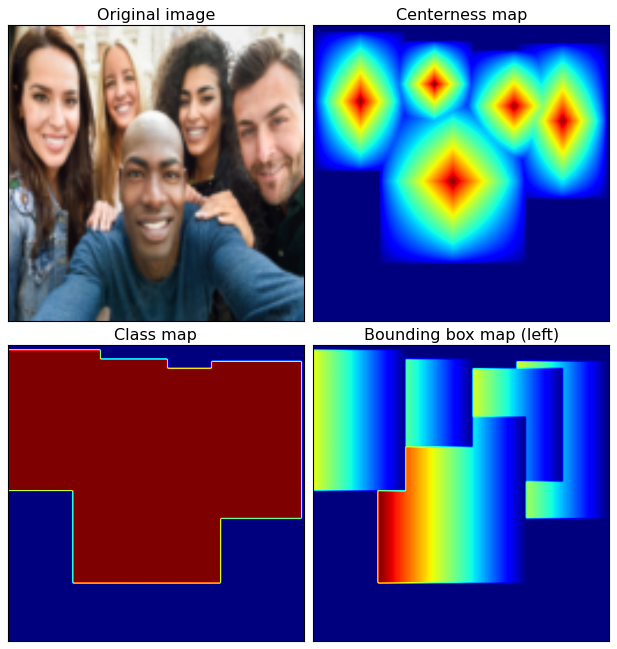

In [10]:
plot_img_and_labels(120)

## FCOS-like architecture

This consists of a feature pyramid network which will forward its output to three different heads 
-   a class head to determine the probability of a pixel belonging to a certain class
-   a bounding box head which determines the bounding box coordinates for a predicted class
-   a centerness head to predict how close a pixel is to the center of that 

In [11]:
class FCOS_NN(nn.Module):
    def __init__(self,num_of_fpn_layers,num_of_classes, num_of_starting_channels = 32, num_of_ending_channels = 128):
        super().__init__()
        self.conv1 = nn.Conv2d(3,num_of_starting_channels,kernel_size=3,padding=1)
        self.fpn = nn.ModuleList()
        self.refine_conv = nn.ModuleList()
        self.upscale = nn.ModuleList()
        input_channels = num_of_starting_channels
        output_channels = num_of_starting_channels*2
        factor = 2
        for _ in range(num_of_fpn_layers):
            self.fpn.append(nn.Sequential(
                nn.Conv2d(input_channels,output_channels,kernel_size=3,stride=2,padding=1),
                nn.BatchNorm2d(output_channels),
                nn.ReLU()
            ))
            self.refine_conv.append(nn.Sequential(
                nn.Conv2d(output_channels,num_of_ending_channels,kernel_size=1,padding=0),
                nn.BatchNorm2d(num_of_ending_channels),
                nn.ReLU()
            ))
            self.upscale.append(
                nn.Upsample(scale_factor=factor,mode='bilinear')
            )
            factor = factor*2
            input_channels = output_channels
            output_channels = output_channels*2
        self.cls_head = nn.Sequential(
            nn.Conv2d(num_of_ending_channels,num_of_ending_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(num_of_ending_channels),
            nn.Conv2d(num_of_ending_channels,num_of_classes,kernel_size=3,padding=1)
        )
        self.bbox_head = nn.Sequential(
            nn.Conv2d(num_of_ending_channels,num_of_ending_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(num_of_ending_channels),
            nn.Conv2d(num_of_ending_channels,4,kernel_size=3,padding=1)
        )
        self.centerness_head = nn.Sequential(
            nn.Conv2d(num_of_ending_channels,num_of_ending_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(num_of_ending_channels),
            nn.Conv2d(num_of_ending_channels,1,kernel_size=3,padding=1)
        )
        

    def forward(self,x):
        feature_layers = []
        x = self.conv1(x)
        for layer in self.fpn:
            x = layer(x)
            feature_layers.append(x)
        for i, (feature,layer) in enumerate(zip(feature_layers,self.refine_conv)):
            feature_layers[i] = layer(feature)
        for i, (feature,layer) in enumerate(zip(feature_layers,self.upscale)):
            feature_layers[i] = layer(feature)
        x = feature_layers[0]
        for i in range(len(feature_layers)-1):
            x = x + feature_layers[i+1]
        cls_pred = self.cls_head(x)
        centerness_pred = self.centerness_head(x)
        bbox_pred = self.bbox_head(x)
        cls_pred = torch.nn.functional.sigmoid(cls_pred)
        centerness_pred = torch.nn.functional.sigmoid(centerness_pred)
        bbox_pred = torch.nn.functional.sigmoid(bbox_pred)
        return torch.cat((centerness_pred,cls_pred,bbox_pred),dim=1)

### Check if it outputs the correct shape

In [12]:
model = FCOS_NN(num_of_fpn_layers = 4,num_of_classes = 1,num_of_ending_channels=256).to(device)
X = torch.rand((1,3,128,128)).to(device)
out = model(X)
out.shape

torch.Size([1, 6, 128, 128])

# Training Loop

Parameters:
-   epoch
-   loss functions
-   optimizer

In [13]:
model = model.to(device)
epochs = 12
optim = torch.optim.AdamW(model.parameters())
bce_loss_fn = torch.nn.BCELoss()
bbox_loss_fn = torch.nn.SmoothL1Loss()
for i in range(epochs):
    bbox_running_loss = 0.
    bce_running_loss = 0.
    last_loss = 0.
    for i,(X,y) in enumerate(tqdm(faces_dataloader)):
        optim.zero_grad()
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        bbox_preds = pred[:,2:,:].permute(0,2,3,1).float()
        left_pred, right_pred, top_pred,  bottom_pred = pred[:, 2, :, :], pred[:, 3, :, :], pred[:, 4, :, :], pred[:, 5, :, :]
        left_true, right_true, top_true,  bottom_true = y[:, 2, :, :], y[:, 3, :, :], y[:, 4, :, :], y[:, 5, :, :]
        left_loss = bbox_loss_fn(left_pred, left_true).mean()
        right_loss = bbox_loss_fn(top_pred, top_true).mean()
        top_loss = bbox_loss_fn(right_pred, right_true).mean()
        bottom_loss = bbox_loss_fn(bottom_pred, bottom_true).mean()
        centerness_bce_loss = bce_loss_fn(pred[:,0,:].float(),y[:,0,:].float()).mean()
        class_bce_loss = bce_loss_fn(pred[:,1,:].float(),y[:,1,:].float()).mean()
        loss = centerness_bce_loss + class_bce_loss + left_loss +right_loss + top_loss + bottom_loss
        loss.backward()
        bbox_running_loss += left_loss.item() +right_loss.item() + top_loss.item() + bottom_loss.item()
        bce_running_loss += centerness_bce_loss.item() + class_bce_loss.item()
        optim.step()
        if i % 100 == 99:
            bbox_last_loss = bbox_running_loss / 100 # loss per batch
            bce_last_loss = bce_running_loss / 100 # loss per batch
            print('  batch {} regression loss: {} , bce_loss: {}'.format(i + 1, bbox_last_loss,bce_last_loss ))
            bbox_running_loss = 0.
            bce_running_loss = 0.

 30%|███       | 101/335 [00:17<00:38,  6.05it/s]

  batch 100 regression loss: 0.2397827380758944 , bce_loss: 0.9722522522509098


 60%|██████    | 201/335 [00:35<00:26,  5.05it/s]

  batch 200 regression loss: 0.061124373104617685 , bce_loss: 0.5639761955291033


 90%|████████▉ | 301/335 [00:52<00:05,  6.37it/s]

  batch 300 regression loss: 0.015916311164638014 , bce_loss: 0.5181916359066964


 30%|███       | 101/335 [00:18<00:38,  6.14it/s]

  batch 100 regression loss: 0.016267996011919264 , bce_loss: 0.5011272020637989


 60%|██████    | 201/335 [00:36<00:23,  5.60it/s]

  batch 200 regression loss: 0.016251369760933342 , bce_loss: 0.4767297126352787


 90%|████████▉ | 301/335 [00:53<00:05,  5.79it/s]

  batch 300 regression loss: 0.01663702557571273 , bce_loss: 0.4717870299518108


 30%|███       | 101/335 [00:18<00:43,  5.43it/s]

  batch 100 regression loss: 0.016433628802584647 , bce_loss: 0.4550129324942827


 60%|██████    | 201/335 [00:38<00:24,  5.40it/s]

  batch 200 regression loss: 0.014571061924005304 , bce_loss: 0.432721449136734


 90%|████████▉ | 301/335 [00:57<00:06,  5.51it/s]

  batch 300 regression loss: 0.012871364053809772 , bce_loss: 0.40102507308125496


 30%|██▉       | 100/335 [00:17<00:39,  5.91it/s]

  batch 100 regression loss: 0.016663489847950547 , bce_loss: 0.41253485329449174


 60%|█████▉    | 200/335 [00:36<00:24,  5.55it/s]

  batch 200 regression loss: 0.0148926404972723 , bce_loss: 0.4079203549027443


 90%|████████▉ | 301/335 [00:53<00:06,  5.58it/s]

  batch 300 regression loss: 0.013053352025478637 , bce_loss: 0.3866266342252493


 30%|███       | 101/335 [00:17<00:40,  5.82it/s]

  batch 100 regression loss: 0.016239673162766338 , bce_loss: 0.40300350069999696


 60%|██████    | 201/335 [00:34<00:22,  5.92it/s]

  batch 200 regression loss: 0.012461044439318917 , bce_loss: 0.3491770997643471


 90%|████████▉ | 301/335 [00:51<00:05,  6.14it/s]

  batch 300 regression loss: 0.014105940354704073 , bce_loss: 0.36647675961256027


 30%|███       | 101/335 [00:17<00:43,  5.34it/s]

  batch 100 regression loss: 0.010485269000325495 , bce_loss: 0.31561573289334777


 60%|██████    | 201/335 [00:34<00:20,  6.45it/s]

  batch 200 regression loss: 0.013734300689691649 , bce_loss: 0.3444346319139004


 90%|████████▉ | 301/335 [00:51<00:06,  5.15it/s]

  batch 300 regression loss: 0.014630570153974337 , bce_loss: 0.342108249142766


 30%|███       | 101/335 [00:16<00:36,  6.46it/s]

  batch 100 regression loss: 0.010710516241317953 , bce_loss: 0.30112613368779423


 60%|██████    | 201/335 [00:33<00:23,  5.77it/s]

  batch 200 regression loss: 0.013162993156031508 , bce_loss: 0.31476298563182353


 90%|████████▉ | 301/335 [00:50<00:05,  6.60it/s]

  batch 300 regression loss: 0.012796068674551988 , bce_loss: 0.3133367226272821


 30%|███       | 101/335 [00:16<00:36,  6.43it/s]

  batch 100 regression loss: 0.012154575877301335 , bce_loss: 0.2900452196225524


 60%|██████    | 201/335 [00:33<00:20,  6.64it/s]

  batch 200 regression loss: 0.010991121003146831 , bce_loss: 0.28102862380445004


 90%|████████▉ | 300/335 [00:50<00:05,  6.41it/s]

  batch 300 regression loss: 0.011557737400979541 , bce_loss: 0.28651349909603596


 30%|███       | 101/335 [00:17<00:36,  6.38it/s]

  batch 100 regression loss: 0.01251039416741303 , bce_loss: 0.27962546024471524


 60%|██████    | 201/335 [00:34<00:20,  6.42it/s]

  batch 200 regression loss: 0.011874535991880703 , bce_loss: 0.2703671931102872


 90%|████████▉ | 301/335 [00:50<00:05,  6.46it/s]

  batch 300 regression loss: 0.009563253803518206 , bce_loss: 0.2497577066719532


 30%|███       | 101/335 [00:16<00:40,  5.83it/s]

  batch 100 regression loss: 0.009789453697570904 , bce_loss: 0.23670128785073757


 60%|██████    | 201/335 [00:33<00:23,  5.69it/s]

  batch 200 regression loss: 0.012012715056035466 , bce_loss: 0.26104545876383783


 90%|████████▉ | 300/335 [00:50<00:06,  5.17it/s]

  batch 300 regression loss: 0.010564700993548986 , bce_loss: 0.2425169175118208


 30%|██▉       | 100/335 [00:16<00:39,  5.93it/s]

  batch 100 regression loss: 0.010365554177604819 , bce_loss: 0.2346214519813657


 60%|██████    | 201/335 [00:34<00:21,  6.09it/s]

  batch 200 regression loss: 0.010629713450095201 , bce_loss: 0.22213464092463256


 90%|████████▉ | 301/335 [00:51<00:05,  6.21it/s]

  batch 300 regression loss: 0.008775654762027137 , bce_loss: 0.2203701250255108


 30%|███       | 101/335 [00:17<00:39,  5.90it/s]

  batch 100 regression loss: 0.009389115927471594 , bce_loss: 0.20834640435874463


 60%|██████    | 201/335 [00:33<00:21,  6.35it/s]

  batch 200 regression loss: 0.008321971661180348 , bce_loss: 0.20511742047965525


 90%|████████▉ | 301/335 [00:50<00:05,  6.14it/s]

  batch 300 regression loss: 0.011850500847831721 , bce_loss: 0.23546140048652886


100%|██████████| 335/335 [00:56<00:00,  5.93it/s]


## Finetune the bbox regression a bit more

In [14]:
epochs = 2
faces_dataloader = DataLoader(ds,batch_size=16,shuffle=True)
optim = torch.optim.AdamW(model.parameters(),lr = 0.0001)
bce_loss_fn = torch.nn.BCELoss()
model.conv1.requires_grad_(False)
model.fpn.requires_grad_(False)
model.upscale.requires_grad_(False)
model.refine_conv.requires_grad_(False)
model.cls_head.requires_grad_(False)
model.centerness_head.requires_grad_(False)
bbox_loss_fn = torch.nn.SmoothL1Loss()
for i in range(epochs):
    for i,(X,y) in enumerate(tqdm(faces_dataloader)):
        optim.zero_grad()
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = 1.1*bbox_loss_fn(pred[:,0,:].float(),y[:,0,:].float()).mean()
        loss.backward()
        optim.step()

100%|██████████| 210/210 [00:28<00:00,  7.47it/s]


## Sanity check of the centerness output multiplied with the class probabilities

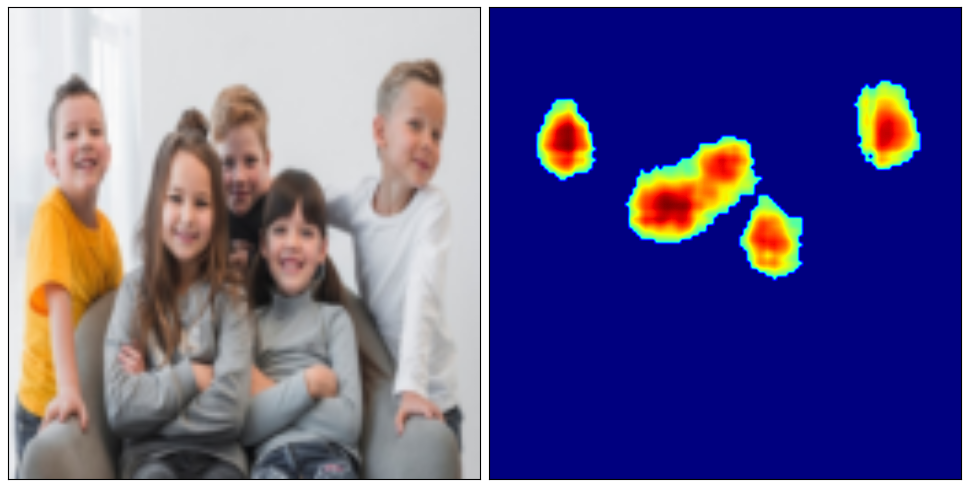

In [15]:
img = ds.get_img(5)[0].view(1,3,128,128).float().to(device)
out = model(img)
bboxes = out[:,2:].cpu().detach().numpy()
probability_map = out[0,0]*out[0,1]
probability_map[probability_map<0.4] = 0.
class_img = probability_map.cpu().detach().numpy()
img = ds.get_img(5)[0] 
fig, axs = plt.subplots(ncols=2,figsize=(12, 8),layout="compressed")
fig.set_facecolor("w")
for ax in axs.reshape(-1):
    ax.set_xticks([])
    ax.set_yticks([])
axs[1].imshow(class_img)
axs[0].imshow(img.permute(1,2,0).int())
plt.show()

## Do the same for bbox map

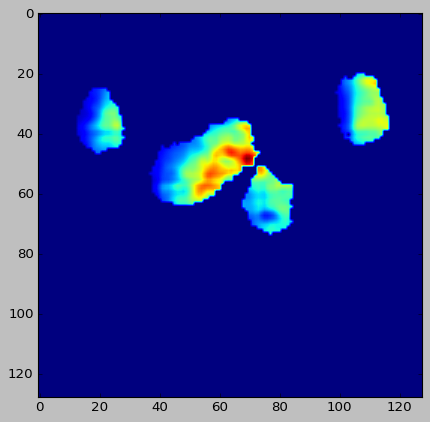

In [16]:
bboxes = out[:,2:].cpu().detach().numpy()
prob_map = probability_map.cpu()
bbox_xmin = bboxes[0,0]
bbox_xmin = np.where(prob_map > 0.2, bbox_xmin, 0)
plt.imshow(bbox_xmin)

## As it can be seen there will be lots of bbox suggestions made by the model and somehow these have to be "filtered" to get the best results: for this Non-Maximum Suppression (NMS) is used with Generalized Intersection over Union (GIoU) loss

In [17]:
def iou(box1, box2):
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])
    
    inter_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)

    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1]) # (x_min - x_max) * (y_min * y_max)
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union_area = area_box1 + area_box2 - inter_area

    iou_value = inter_area / float(union_area) if union_area > 0 else 0.0

    return iou_value

def non_max_suppression(boxes, scores, cls_probs, threshold=0.5):

    # If no high probability boxes are predicted
    if len(boxes) == 0:
        return [[],[]]

    indices = np.argsort(scores)[::-1]
    selected_boxes = []
    probabilities = []

    while len(indices) > 0:
        current_idx = indices[0]
        probabilities.append(cls_probs[current_idx])
        selected_boxes.append(boxes[current_idx])

        remaining_boxes = boxes[indices[1:]]
        iou_values = np.array([iou(boxes[current_idx], box) for box in remaining_boxes])
        
        # iou is too small it gets removed
        indices = indices[1:][iou_values < threshold]

    return np.array(selected_boxes),np.array(probabilities)

In [18]:
def inference_on_img_by_idx(idx, probability_threshold =  0.4 ,nms_threshold = 0.05):
    model.eval()

    with torch.no_grad():
        start_time = time.time()

        image_to_plot = test_dataset.dataset.get_img(idx)[0]
        image_to_plot = image_to_plot.permute(1,2,0)
        image_to_plot = image_to_plot.numpy().reshape(128,128,3)
        img = ds.get_img(idx)[0].view(1, 3, 128, 128).float().to(device)
        out = model(img)

        bboxes = out[:, 2:].cpu().detach().numpy()

        class_map = out[0, 0]
        centerness_map = out[0, 1]
        probability_map = class_map * centerness_map
        probability_map[probability_map < probability_threshold] = 0.

        valid_y, valid_x = np.nonzero(probability_map.cpu().detach().numpy())
        boxes = []
        scores = []
        cls_prob = []

        for y, x in zip(valid_y, valid_x):
            d_t = bboxes[0, 0, y, x] * 128  
            d_b = bboxes[0, 1, y, x] * 128  
            d_l = bboxes[0, 2, y, x] * 128  
            d_r = bboxes[0, 3, y, x] * 128

            xmin = int(x - d_l)
            ymin = int(y - d_t)
            xmax = int(x + d_r)
            ymax = int(y + d_b)

            if xmax > xmin and ymax > ymin:
                boxes.append((xmin, ymin, xmax, ymax))
                scores.append(probability_map[y, x].item())
                cls_prob.append(class_map[y, x].item())


        boxes = np.array(boxes)
        scores = np.array(scores)
        cls_prob = np.array(cls_prob)

        final_boxes,final_probabilities = non_max_suppression(boxes, scores, cls_prob, nms_threshold)

        plt.imshow(image_to_plot)
        for box,prob in zip(final_boxes,final_probabilities):
            xmin, ymin, xmax, ymax = box
            plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                            fill=False, edgecolor='red', linewidth=2))
            plt.text(xmax-10, ymin-1,f'Conf {(prob*100):.2f}%', fontsize=13,color = 'red')

        plt.axis('off')
        plt.show()

        end_time = time.time()
        total_time = end_time - start_time
        print(f"Total time for detection: {total_time:.4f} seconds")

 Params could be tuned to further enhance predictions, but these numbers seem to be working fine for me

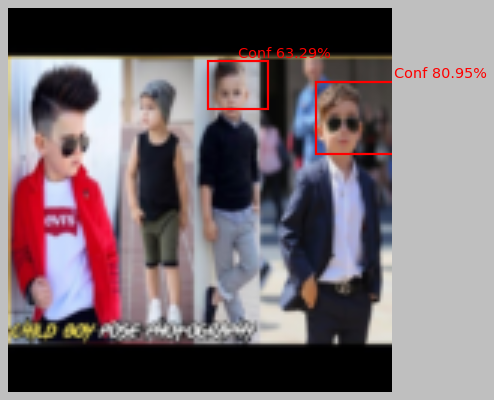

Total time for detection: 0.1728 seconds


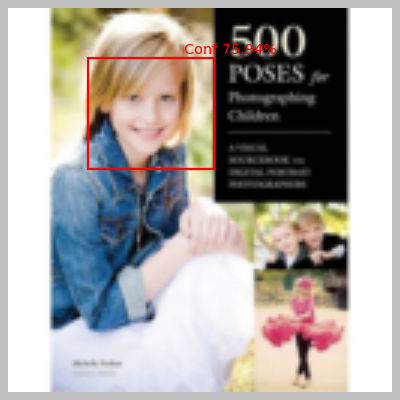

Total time for detection: 0.2457 seconds


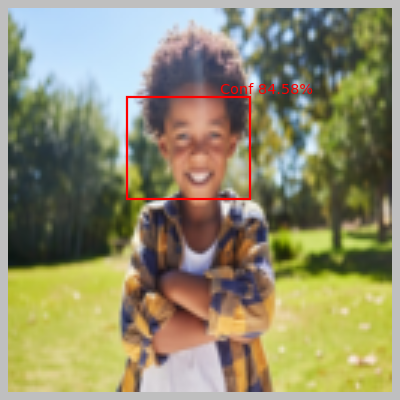

Total time for detection: 0.1180 seconds


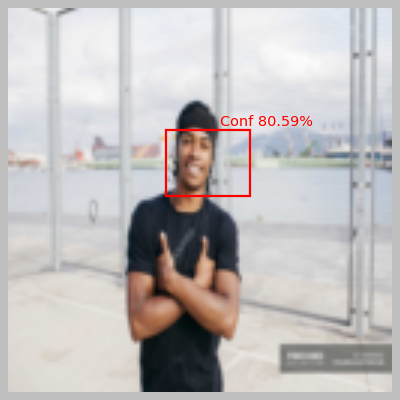

Total time for detection: 0.1016 seconds


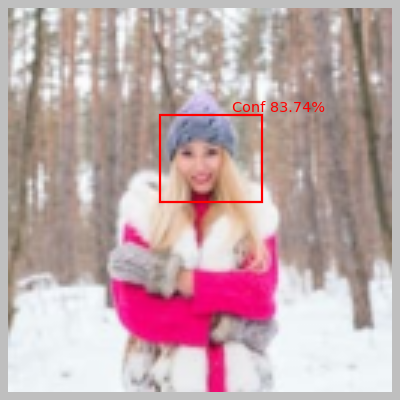

Total time for detection: 0.0873 seconds


In [34]:
idxs = np.random.randint(0,test_dataset.__len__(),5)
for idx in idxs:
    inference_on_img_by_idx(idx,probability_threshold=0.60,nms_threshold=0.05)

# Save model to use it later

In [20]:
torch.save(model.state_dict(), "model/FCOS_ish.pt")